# [IAPR 2019:][iapr2019] Special project

**Group members:**     
    1 - Tianlun Luo,     
    2 - Yue Xu,     
    3 - Earvin Tio         

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

In [7]:
import tarfile
import os
import cv2
import numpy as np
import skimage.io
from skimage.measure import label, regionprops
from skimage.feature import canny
import random

import sklearn
from sklearn import linear_model


import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [8]:
# getting data
data_base_path = 'project-data'
images_path = os.path.join(data_base_path, 'images')
test_images_path = os.path.join(images_path, 'test')
train_images_path = os.path.join(images_path, 'train')
validation_images_path = os.path.join(images_path, 'validation')

labels_path = os.path.join(data_base_path, 'annotations')
test_labels_path = os.path.join(labels_path, 'test')
train_labels_path = os.path.join(labels_path, 'train')
validation_labels_path = os.path.join(labels_path, 'validation')

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [74]:
# histogram equalization for colored image
# borrowed from source: https://stackoverflow.com/questions/31998428/opencv-python-equalizehist-colored-image
def equalize_hist(img):
    for c in range(0, 2):
        img[:,:,c] = cv2.equalizeHist(img[:,:,c])

    cv2.imshow('Histogram equalized', img)
    cv2.waitKey(0)

    return img

# threshold the image
def thresh(image, th1, th2): 
    return cv2.inRange(image, th1, th2)

In [270]:
# method 1: preprocess + thresholding
def detect_by_segmentation(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    
    th1_bee = 0
    th2_bee = 80
    
# Enhance the background by doing thresholding for the background
#################################################################################
    background_th = 300
    img_sum = np.sum(img, axis=2)
    new_image = img.copy()
    
    white = np.full((img.shape[0], img.shape[1]), 200)
    new_image[:,:,0] = np.where(img_sum <= background_th, img[:,:,0], white)
    new_image[:,:,1] = np.where(img_sum <= background_th, img[:,:,1], white)
    new_image[:,:,2] = np.where(img_sum <= background_th, img[:,:,2], white)

#    plt.imshow(new_image)

#################################################################################
    
    
    gray_img = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((6,6),np.uint8)
    blur = cv2.medianBlur(gray_img, 15)
    blur = cv2.erode(blur, kernel, iterations = 1)
    thresh_img = thresh(blur, th1_bee, th2_bee)   
    label_img, num_components = skimage.measure.label(thresh_img, connectivity=2, return_num=True)
#     plt.imshow(thresh_img, cmap='gray')
#     print("Number of Varroa detected:", num_components)
    bboxes = skimage.measure.regionprops(label_img)    
    
    res = [bboxes[i]['bbox'] for i in range(len(bboxes))]
    
    return res



In [375]:
from skimage.segmentation import morphological_chan_vese, checkerboard_level_set
from skimage.measure import label, regionprops
import numpy as np

In [374]:
# method 2: using level set and shape descriptors
def detect_by_segmentation_2(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    t1, t2 = 1, 50                                       # NEED TO MANUALLY DETERMINE THIS THRESHOLD

    th_img = 255*gray_img.copy()
    th_img[th_img<t1] = 0
    th_img[th_img>t2] = 0
    th_img[(th_img>=t1) & (th_img<=t2)] = 255

    init_ls = checkerboard_level_set(th_img.shape, 6)
    ls = morphological_chan_vese(th_img, 60, init_level_set=init_ls, smoothing=3)

    # label image regions
    labelled_ls, num_of_reg = label(ls,return_num=True)

    if num_of_reg == 1:
        ls = 1 - ls
        labelled_ls, num_of_reg = label(ls,return_num=True)

    regions = regionprops(labelled_ls)

    # The sphercity equation is used here to reject any regions that are not round
    # spheres have a sphercity factor of 1
    
    spherical = []

    for region in regions:
        if (4*np.pi*region.area)/np.square(region.perimeter) > 0.75:            # THIS IS ARBITRARY
            spherical.append(region)
        
    candidates = []
    
    # Initially we wanted to exclude outliers in the statistical sense
    # but we found this to be too restrictive
    
    # area = [ region.area for region in spherical ]
    # q1,q3 = np.percentile(area, [25, 75])
    # iqr = q3 - q1
    # lowerbound = q1 - (1.5 * iqr) 
    # upperbound = q3 + (1.5 * iqr)

    # for region in spherical:
    #     if region.area > lowerbound and region.area < upperbound:
    #         candidate.append(region.bbox)

    for region in spherical:
        # instead we take regions with large enough areas
        if region.area > 300:                                                # THIS IS ALSO ARBITRARY
            # draw rectangle around segmented varroa
            candidates.append(region.bbox)

    #print("Number of Varroa detected:", len(candidates))
    
    return candidates                               # THIS ISNT EXACTLY THE OUTPUT FORMAT HE ASKED FOR

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [271]:
# Retrive the images
im_names = os.listdir(test_images_path)
test_images_names = [os.path.join(test_images_path, name) for name in im_names]
test_images_list = skimage.io.imread_collection(test_images_names)
print("Number of images:", len(test_images_list))

Number of images: 50


In [272]:
# parsing the xml file for the ground truth
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [273]:
# xml file names 
xml_names = os.listdir(test_labels_path)

# list of path to ground truth xml files
ground_truth_files = [os.path.join(test_labels_path, name) for name in xml_names]

# parse each xml file
annotations_xmls = [parse_file(file) for file in ground_truth_files]

number of Varroa detected: 19
ground truth number of Varroa: 6


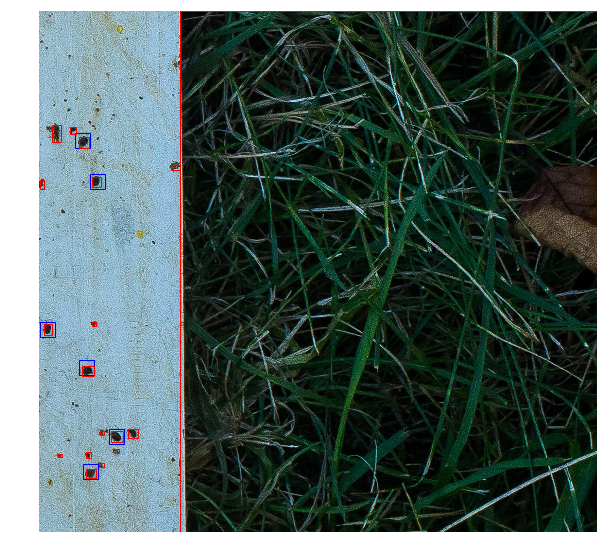

In [274]:
# Visualize the ground truth and the detected pattern
# enter an index for a test image

sample_idx = 3
annoations = annotations_xmls[sample_idx]
bboxes = detect_by_segmentation(test_images_list[sample_idx])
print("number of Varroa detected:", len(bboxes))
print("ground truth number of Varroa:", len(annoations))
fig, ax = plt.subplots(figsize=(10,10))
for anno in annoations:
    rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
            linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)
    
for i in range(len(bboxes)):

    ymin = bboxes[i][0]
    xmin = bboxes[i][1]
    ymax = bboxes[i][2]
    xmax = bboxes[i][3]

    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

ax.imshow(test_images_list[sample_idx])
ax.axis('off')

plt.show()

In [275]:
# function to find IoU
# modified from https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def iou(boxA, boxB): 

    # x and y are flipped for ground truth bb and detected bb
    xA = max(boxA[0], boxB[1])
    yA = max(boxA[1], boxB[0])
    xB = min(boxA[2] + boxA[0], boxB[3])
    yB = min(boxA[3] + boxA[1], boxB[2])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

In [280]:
# function to find the best match bewteen bounding boxes of ground truth and detected, compute IOU of the best match
def match_bboxes_iou(ground_truth, detected_pattern):
    
    curr_detected = detected_pattern
    curr_ground_truth = ground_truth
    
    curr_image_ious = []
    visited = np.zeros(len(curr_detected))

    # loop through each bounding box in the ground truth, trying to match each ground truth with a detected value
    for j in range(len(curr_ground_truth)): 
            
        # compute all possible iou value with the current ground truth, pick the largest IoU value as the matching pair
        del_idx = -1
        max_iou = -1

        for k in range(len(curr_detected)): 
            
            if(visited[k] != 0): 
                continue
                
            curr_iou = iou(curr_ground_truth[j]['bbox'], curr_detected[k])
            if max_iou < curr_iou:
                
                max_iou = curr_iou
                del_idx = k        
        
        curr_image_ious.append(max_iou)    
        visited[del_idx] = 1

        if(len(curr_detected) <= 0): 
            break 
        
    return curr_image_ious

In [279]:
# calcuate precision, recall, and F1 score for the test set
T = 0.3

tp_all = 0
fp_all = 0
fn_all = 0

for i in range(len(test_images_list)):
    
    ground_truth = annotations_xmls[i]
    detected_pattern = detect_by_segmentation(test_images_list[i])
    
    ious = match_bboxes_iou(ground_truth, detected_pattern)
    above_thresh = np.where(np.array(ious) > T)
    
    tp = len(above_thresh[0])
    fp = len(detected_pattern) - tp
    
    # number of Varroa in the groud truth - number of Varroa that we detected
    fn = max(0, len(ground_truth) - len(detected_pattern)) + len(np.where(np.array(detected_pattern) == 0)[0])
    
    if float(tp + fp) == 0:
        precision = 0
    else:
        precision = tp / float(tp + fp)
    
    if  float(tp + fn) == 0:
        recall = 1
    else:
        recall = tp / float(tp + fn)
        
        
    if (precision + recall) == 0:
        f1 = 0
    else:
        f1 = (2 * precision * recall) / (precision + recall)
    
    print("Test image", i, "precision:", precision, "recall:", recall, "f1 score:", f1)
    
    tp_all += tp
    fp_all += fp
    fn_all += fn
    

precision = tp_all / float(tp_all + fp_all)
recall = tp_all / float(tp_all + fn_all)
f1 = (2 * precision * recall) / (precision + recall)

print()
print("================================================================================")
print("Overall")
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


Test image 0 precision: 0.0 recall: 0.0 f1 score: 0
Test image 1 precision: 0.3404255319148936 recall: 0.6597938144329897 f1 score: 0.44912280701754387
Test image 2 precision: 0.006896551724137931 recall: 0.25 f1 score: 0.013422818791946308
Test image 3 precision: 0.3157894736842105 recall: 0.75 f1 score: 0.44444444444444436
Test image 4 precision: 0.1875 recall: 1.0 f1 score: 0.3157894736842105
Test image 5 precision: 0.0 recall: 0.0 f1 score: 0
Test image 6 precision: 0.013089005235602094 recall: 0.20833333333333334 f1 score: 0.02463054187192118
Test image 7 precision: 0.09523809523809523 recall: 0.8 f1 score: 0.1702127659574468
Test image 8 precision: 0.32663316582914576 recall: 0.9701492537313433 f1 score: 0.4887218045112782
Test image 9 precision: 0.03977272727272727 recall: 1.0 f1 score: 0.07650273224043716
Test image 10 precision: 0.19148936170212766 recall: 0.75 f1 score: 0.3050847457627119
Test image 11 precision: 0.18181818181818182 recall: 0.8571428571428571 f1 score: 0.3000

## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [356]:
im_names = os.listdir(train_images_path)
train_images_names = [os.path.join(train_images_path, name) for name in im_names]
train_images_list = skimage.io.imread_collection(train_images_names)
print("Number of train images:", len(train_images_list))

Number of train images: 800


In [357]:
# xml file names 
xml_names = os.listdir(train_labels_path)

# list of path to ground truth xml files
ground_truth_files = [os.path.join(train_labels_path, name) for name in xml_names]

# parse each xml file
annotations_xmls = [parse_file(file) for file in ground_truth_files]

print(len(annotations_xmls))

800


In [358]:
# function to calculate iou, different from part 1 since the bboxes are formatted differently
def iou2(a, b):
# determine the (x, y)-coordinates of the intersection rectangle
    boxA = [a[0], a[1], a[0]+a[2], a[1]+a[3]]
    boxB = [b[0], b[1], b[0]+b[2], b[1]+b[3]]

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [359]:
# generate nagative training samples for each image, returned as a list of bounding boxes
# in the form [x, y, w, h]
def generate_negative_samples(image_list, train_img_idx, anno):
    
    bbox_width = 30
    bbox_height = 30
    
    img = image_list[train_img_idx]
    ground_truth = anno[train_img_idx]
    
    num_ground_truth = len(ground_truth)
    num_neg_samples_remain = num_ground_truth
    
    img_width = img.shape[1]
    img_height = img.shape[0]
    
    negative_samples = []
    
    # generate the same number of negative samples as positive samples
    while num_neg_samples_remain > 0:
        
        # randomly generate a point in with the image and construct a bounding box around it
        x, y = random.randint(0, img_width - bbox_width), random.randint(0, img_height - bbox_height)
        bbox = [x, y, bbox_width, bbox_height]
        overlap_flag = False

        # check if the randomly generated bounding box overlaps with the ground truth bounding box
        for i in range(num_ground_truth):
            ground_truth_bbox = ground_truth[i]['bbox']
    
            if iou2(bbox, ground_truth_bbox) != 0:
                overlap_flag = True
                # print("overlap with ground truth!")
                break
                
        # check overlap with exisiting negative samples
        for i in range(len(negative_samples)):
            if iou2(bbox, negative_samples[i]) != 0:
                overlap_flag = True
                # print("overlap with existing samples!")
                break
        
        if overlap_flag == True:
            continue
        else:
            negative_samples.append(bbox)
            num_neg_samples_remain = num_neg_samples_remain - 1
    
    return negative_samples
    

In [360]:
# generate nagative training samples for each image, returned as a list of bounding boxes
# in the form [x, y, w, h], biased toward darker samples
def generate_negative_samples_2(train_img_idx):
    
    bbox_width = 30
    bbox_height = 30
    
    img = train_images_list[train_img_idx]
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mean_gray_img = np.mean(gray_img)
    std_gray_img = np.std(gray_img)
    
    ground_truth = annotations_xmls[train_img_idx]
    
    num_ground_truth = len(ground_truth)
    num_neg_samples_remain = num_ground_truth
    
    img_width = img.shape[1]
    img_height = img.shape[0]
    
    negative_samples = []
    
    # generate the same number of negative samples as positive samples
    while num_neg_samples_remain > 0:
        
        # randomly generate a point in with the image and construct a bounding box around it
        x, y = random.randint(0, img_width - bbox_width), random.randint(0, img_height - bbox_height)
        bbox = [x, y, bbox_width, bbox_height]
        overlap_flag = False
        
        window = img[y:y+bbox_width, x:x+bbox_height]
        
        gray = cv2.cvtColor(window, cv2.COLOR_BGR2GRAY)
        
        # only generate dark windows
        mean_gray_level = np.mean(gray)

        if num_neg_samples_remain < num_ground_truth/2:
            if mean_gray_level > mean_gray_img - std_gray_img and mean_gray_level > 100:
                continue
        
        # check if the randomly generated bounding box overlaps with the ground truth bounding box
        for i in range(num_ground_truth):
            ground_truth_bbox = ground_truth[i]['bbox']
    
            if iou2(bbox, ground_truth_bbox) != 0:
                overlap_flag = True
                break
                
        # check overlap with exisiting negative samples
        for i in range(len(negative_samples)):
            if iou2(bbox, negative_samples[i]) != 0:
                overlap_flag = True
                break
        
        if overlap_flag == True:
            continue
        else:
            negative_samples.append(bbox)
            num_neg_samples_remain = num_neg_samples_remain - 1
    
    return negative_samples
    

8


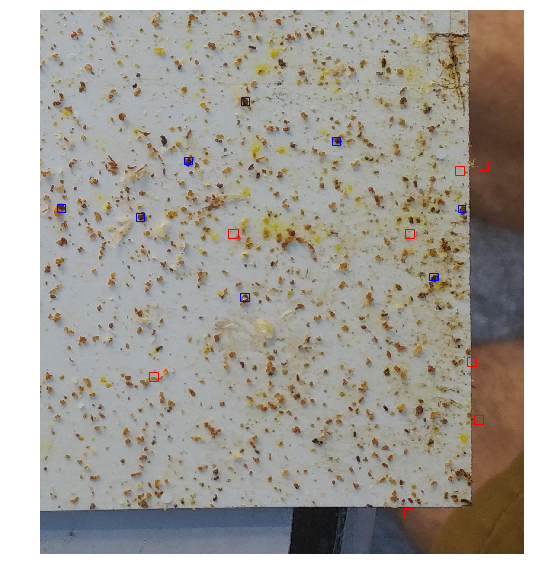

In [361]:
# visualize the positive and negative samples in a particular training image
train_idx = 523
negative_samples = generate_negative_samples_2(train_idx)
annoations = annotations_xmls[train_idx]

print(len(annoations))

fig, ax = plt.subplots(figsize=(10,10))
for i in range(len(negative_samples)):

    xmin = negative_samples[i][0]
    ymin = negative_samples[i][1]
    xw = negative_samples[i][2]
    yw = negative_samples[i][3]

    rect = patches.Rectangle((xmin, ymin), xw, yw,
            linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    

for i in range(len(annoations)):

    xmin = annoations[i]['bbox'][0]
    ymin = annoations[i]['bbox'][1]
    xw = annoations[i]['bbox'][2]
    yw = annoations[i]['bbox'][3]

    yee = train_images_list[train_idx][ymin:ymin+yw, xmin:xmin+xw]

    rect = patches.Rectangle((xmin, ymin), xw, yw,
            linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

ax.imshow(train_images_list[train_idx])
ax.axis('off')

plt.show()

### Method 1: Fourier Descriptors

In [362]:
# Calcuates the covariance matrix of an image
def calculateCovariance(X):
    meanX = np.mean(X, axis=0)
    lenX = X.shape[0]
    X = X - meanX
    covariance = X.T.dot(X)/lenX
    return covariance

In [363]:
# generate training data
# call generate_negative_sample
# generate same number of negative samples as positive ones
# for each sample, exact fourier descriptor, moments and axis of inertia to construct a feature vector

train_data = []
train_labels = []

for i in range(len(train_images_list)):
    print("image", i)
    curr_image = train_images_list[i]
    
    # generate negative samples from current image
    curr_negative_samples = generate_negative_samples_2(i)
    
    # get the ground truth bounding boxes
    annoations = annotations_xmls[i]

    # construct window defined by the negative samples and extract features
    for j in range(len(curr_negative_samples)):
        
        negative_bbox = curr_negative_samples[j]
        ground_truth_bbox = annoations[j]['bbox']
        
        x = negative_bbox[0]
        y = negative_bbox[1]
        w = negative_bbox[2]
        h = negative_bbox[3]
        
        negative_window = curr_image[y:y+h, x:x+w, :]
        
        # do the same thing for the ground truth
        g_x = ground_truth_bbox[0]
        g_y = ground_truth_bbox[1]
        g_w = ground_truth_bbox[2]
        g_h = ground_truth_bbox[3]
        
        positive_window = curr_image[g_y:g_y+g_h, g_x:g_x+g_w, :]
                
        negative_feature_vector = []
        positive_feature_vector = []

        ################################### FOURIER DESCRIPTOR ####################################
        ### NEGATIVE SAMPLES ######################################################################
        negative_gray_window = cv2.cvtColor(negative_window, cv2.COLOR_BGR2GRAY)
          
        edges = canny(negative_gray_window)
        label_image = skimage.measure.label(edges)
        props = regionprops(label_image)
        areas = np.array([prop.area for prop in props])
        
        if len(areas) == 0:
            continue

        max_area_idx = np.argmax(areas)
        contour_coords = props[max_area_idx].coords

        # construct complex numbers
        contour_complex = np.empty(contour_coords.shape[:-1], dtype=complex)
        contour_complex.real = contour_coords[:, 0]
        contour_complex.imag = contour_coords[:, 1]

        #perform discrete fourier transform
        fourier_descriptors = np.fft.fft(contour_complex)
        
        
        # not enough fourier descriptors for the contour
        if len(fourier_descriptors) < 4:
            continue
            
        # append to feature vector
        negative_feature_vector.append(abs(fourier_descriptors[1]))
        negative_feature_vector.append(abs(fourier_descriptors[2]))
        
        ### POSITIVE SAMPLES #######################################################################
        
        positive_gray_window = cv2.cvtColor(positive_window, cv2.COLOR_BGR2GRAY)
          
        edges = canny(positive_gray_window)
        label_image = skimage.measure.label(edges)
        props = regionprops(label_image)
        areas = np.array([prop.area for prop in props])
        
        if len(areas) == 0:
            continue

        max_area_idx = np.argmax(areas)
        contour_coords = props[max_area_idx].coords

        # construct complex numbers
        contour_complex = np.empty(contour_coords.shape[:-1], dtype=complex)
        contour_complex.real = contour_coords[:, 0]
        contour_complex.imag = contour_coords[:, 1]

        #perform discrete fourier transform
        fourier_descriptors = np.fft.fft(contour_complex)
        
        # not enough fourier descriptors for the contour
        if len(fourier_descriptors) < 4:
            continue
            
        # append to feature vector
        positive_feature_vector.append(abs(fourier_descriptors[1]))
        positive_feature_vector.append(abs(fourier_descriptors[2]))       
        
        
        ################################### HU MOMENTS ############################################
        ### NEGATIVE SAMPLES ######################################################################
        im = cv2.HuMoments(cv2.moments(negative_gray_window)).flatten()
        im = -np.sign(im) * np.log10(np.abs(im))

        negative_feature_vector.append(im[1])
        negative_feature_vector.append(im[2])
        
        ### POSITIVE SAMPLES ######################################################################
        im = cv2.HuMoments(cv2.moments(positive_gray_window)).flatten()
        im = -np.sign(im) * np.log10(np.abs(im))

        positive_feature_vector.append(im[1])
        positive_feature_vector.append(im[2])
        
        ################################# AXIS OF INERTIA #########################################
        ### NEGATIVE SAMPLES ######################################################################
        cov = calculateCovariance(negative_gray_window)
            
        # Calcuate eigenvalues and eigenvectors
        e_vals, e_vecs = np.linalg.eig(cov)            
#         negative_feature_vector.append(abs(e_vals[0]))
#         negative_feature_vector.append(abs(e_vals[1]))
        
        train_data.append(negative_feature_vector)
        train_labels.append(0)
                
        ### POSITIVE SAMPLES ######################################################################
        cov = calculateCovariance(positive_gray_window)
            
        # Calcuate eigenvalues and eigenvectors
        e_vals, e_vecs = np.linalg.eig(cov)            
#         positive_feature_vector.append(abs(e_vals[0]))
#         positive_feature_vector.append(abs(e_vals[1]))
        
        train_data.append(positive_feature_vector)
        train_labels.append(1)
        

image 0
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
image 28
image 29
image 30
image 31
image 32
image 33
image 34
image 35
image 36
image 37
image 38
image 39
image 40
image 41
image 42
image 43
image 44
image 45
image 46
image 47
image 48
image 49
image 50
image 51
image 52
image 53
image 54
image 55
image 56
image 57
image 58
image 59
image 60
image 61
image 62
image 63
image 64
image 65
image 66
image 67
image 68
image 69
image 70
image 71
image 72
image 73
image 74
image 75
image 76
image 77
image 78
image 79
image 80
image 81
image 82
image 83
image 84
image 85
image 86
image 87
image 88
image 89
image 90
image 91
image 92
image 93
image 94
image 95
image 96
image 97
image 98
image 99
image 100
image 101
image 102
image 103
image 104
image 105
image 106
image 107
image 108
image 109
image 110


In [364]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)

In [365]:
# define classifier
classifier = sklearn.svm.SVC()
classifier.fit(train_data, train_labels)

C:\Users\tluo2\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [366]:
# sliding window
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    w_width = w_height = 30
    stepSize = 30
    
    bboxes = []

    # loop through sliding windows
    for x in range(0, img.shape[1] - w_width , stepSize):
        for y in range(0, img.shape[0] - w_height, stepSize):
            
            feature_vector = []
            
            # create sliding window the current frame
            window = img[x:x + w_width, y:y + w_height, :]
            
            # boundary case
            if window.shape[0] == 0 or window.shape[1] == 0:
                continue

            #################################### FOURIER DESCRIPTOR #################################
            # find the fourier descriptors of contour:
            gray_window = cv2.cvtColor(window, cv2.COLOR_BGR2GRAY)
            
            edges = canny(gray_window)
            label_image = skimage.measure.label(edges)
            props = regionprops(label_image)
            areas = np.array([prop.area for prop in props])

            if len(areas) == 0:
                continue
            
            max_area_idx = np.argmax(areas)
            contour_coords = props[max_area_idx].coords
            
            # construct complex numbers
            contour_complex = np.empty(contour_coords.shape[:-1], dtype=complex)
            contour_complex.real = contour_coords[:, 0]
            contour_complex.imag = contour_coords[:, 1]
            
            #perform discrete fourier transform
            fourier_descriptors = np.fft.fft(contour_complex)

            # not enough fourier descriptors for the contour
            if len(fourier_descriptors) < 4:
                continue
                
#             if abs(fourier_descriptors[3]) < 0.001:
#                 continue

            feature_vector.append(abs(fourier_descriptors[1]))
            feature_vector.append(abs(fourier_descriptors[2]))

            #################################### HU MOMENTS #################################

            im = cv2.HuMoments(cv2.moments(gray_window)).flatten()
            im = -np.sign(im) * np.log10(np.abs(im))

            feature_vector.append(im[1])
            feature_vector.append(im[2])
            
            
            #################################### AXIS OF INERTIA #############################
            cov = calculateCovariance(gray_window)

            # Calcuate eigenvalues and eigenvectors
            e_vals, e_vecs = np.linalg.eig(cov)            
#             feature_vector.append(abs(e_vals[0]))
#             feature_vector.append(abs(e_vals[1]))
                        
            # pass feature vector into classifier
            prediction = classifier.predict(np.array(feature_vector).reshape(-1, 1).T)

            if prediction[0] == 1:
                bboxes.append([y, x, w_width, w_height])
                
    return bboxes
            
    

In [367]:
# Retrive the images
im_names = os.listdir(test_images_path)
test_images_names = [os.path.join(test_images_path, name) for name in im_names]
test_images_list = skimage.io.imread_collection(test_images_names)
print("Number of images:", len(test_images_list))

Number of images: 50


In [368]:
# xml file names 
xml_names = os.listdir(test_labels_path)

# list of path to ground truth xml files
ground_truth_files = [os.path.join(test_labels_path, name) for name in xml_names]

# parse each xml file
annotations_xmls = [parse_file(file) for file in ground_truth_files]

ground truth number: 217
number detected: 534


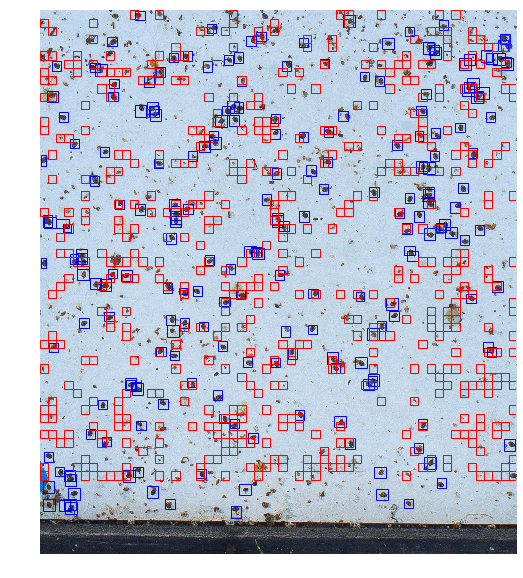

In [369]:
# visualize detected pattern vs ground truth in a test image
sample_idx = 1
detected_pattern = detect_by_method_1(test_images_list[sample_idx])
annoations = annotations_xmls[sample_idx]

print("ground truth number:", len(annoations))
print("number detected:", len(detected_pattern))
fig, ax = plt.subplots(figsize=(10,10))
for i in range(len(annoations)):

    xmin = annoations[i]['bbox'][0]
    ymin = annoations[i]['bbox'][1]
    xw = annoations[i]['bbox'][2]
    yw = annoations[i]['bbox'][3]
    

    rect = patches.Rectangle((xmin, ymin), xw, yw,
            linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)
    

for i in range(len(detected_pattern)):
    xmin = detected_pattern[i][0]
    ymin = detected_pattern[i][1]
    xw = detected_pattern[i][2]
    yw = detected_pattern[i][3]

    rect = patches.Rectangle((xmin, ymin), xw, yw,
            linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

ax.imshow(test_images_list[sample_idx])
ax.axis('off')
plt.show()

In [371]:
# function to find the best match bewteen bounding boxes of ground truth and detected, compute IOU of the best match
def match_bboxes_iou_2(ground_truth, detected_pattern):
    
    curr_detected = detected_pattern
    curr_ground_truth = ground_truth
    
    curr_image_ious = []

    # loop through each bounding box in the ground truth, trying to match each ground truth with a detected value
    for j in range(len(curr_ground_truth)): 
            
        # compute all possible iou value with the current ground truth, pick the largest IoU value as the matching pair
        del_idx = -1
        max_iou = -1
        visited = np.zeros(len(curr_detected))

        for k in range(len(curr_detected)): 
            
            if(visited[k] != 0): 
                continue
                
            curr_iou = iou2(curr_ground_truth[j]['bbox'], curr_detected[k])
            if max_iou < curr_iou:
                
                max_iou = curr_iou
                del_idx = k        
        
        curr_image_ious.append(max_iou)    
        visited[del_idx] = 1

        if(len(curr_detected) <= 0): 
            break 
        
    return curr_image_ious

In [372]:
# calcuate precision, recall, and F1 score for the test set
T = 0.3

tp_all = 0
fp_all = 0
fn_all = 0

for i in range(len(test_images_list)):
    
    ground_truth = annotations_xmls[i]
    detected_pattern = detect_by_method_1(test_images_list[i])
    
    ious = match_bboxes_iou_2(ground_truth, detected_pattern)
    above_thresh = np.where(np.array(ious) > T)
    
    tp = len(above_thresh[0])
    fp = len(detected_pattern) - tp
    
    # number of Varroa in the groud truth - number of Varroa that we detected + any matches with 0 iou
    fn = max(0, len(ground_truth) - len(detected_pattern)) + len(np.where(np.array(detected_pattern) == 0)[0])
    
    if float(tp + fp) == 0:
        precision = 0
    else:
        precision = tp / float(tp + fp)
    
    if  float(tp + fn) == 0:
        recall = 1
    else:
        recall = tp / float(tp + fn)
        
    if (precision + recall) == 0:
        f1 = 0
    else:
        f1 = (2 * precision * recall) / (precision + recall)
    
    print("Test image", i, "precision:", precision, "recall:", recall, "f1 score:", f1)
    
    tp_all += tp
    fp_all += fp
    fn_all += fn
    

precision = tp_all / float(tp_all + fp_all)
recall = tp_all / float(tp_all + fn_all)
f1 = (2 * precision * recall) / (precision + recall)

print()
print("================================================================================")
print("Overall")
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


Test image 0 precision: 0.0 recall: 0.0 f1 score: 0
Test image 1 precision: 0.15917602996254682 recall: 0.7870370370370371 f1 score: 0.264797507788162
Test image 2 precision: 0.0 recall: 0.0 f1 score: 0
Test image 3 precision: 0.002449979583503471 recall: 0.061224489795918366 f1 score: 0.004711425206124852
Test image 4 precision: 0.0 recall: 0.0 f1 score: 0
Test image 5 precision: 0.0 recall: 0.0 f1 score: 0
Test image 6 precision: 0.016339869281045753 recall: 0.23809523809523808 f1 score: 0.030581039755351685
Test image 7 precision: 0.06818181818181818 recall: 0.6 f1 score: 0.1224489795918367
Test image 8 precision: 0.1171875 recall: 0.8333333333333334 f1 score: 0.2054794520547945
Test image 9 precision: 0.004705882352941176 recall: 0.2 f1 score: 0.009195402298850573
Test image 10 precision: 0.01279317697228145 recall: 0.2 f1 score: 0.024048096192384773
Test image 11 precision: 0.07534246575342465 recall: 0.5789473684210527 f1 score: 0.13333333333333333
Test image 12 precision: 0.0134

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [216]:
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [192]:
im_names = os.listdir(train_images_path)
train_images_names = [os.path.join(train_images_path, name) for name in im_names]
train_images_list = skimage.io.imread_collection(train_images_names)
print("Number of train images:", len(train_images_list))

Number of train images: 800


In [194]:
# xml file names 
xml_names = os.listdir(train_labels_path)

# list of path to ground truth xml files
ground_truth_files = [os.path.join(train_labels_path, name) for name in xml_names]

# parse each xml file
train_annotations_xmls = [parse_file(file) for file in ground_truth_files]

print(len(train_annotations_xmls))

800


In [373]:
# xml file names 
xml_names = os.listdir(test_labels_path)

# list of path to ground truth xml files
ground_truth_files = [os.path.join(test_labels_path, name) for name in xml_names]

# parse each xml file
test_annotations_xmls = [parse_file(file) for file in ground_truth_files]

In [201]:
# generate nagative training samples for each image, returned as a list of bounding boxes
# in the form [x, y, w, h]
def generate_negative_samples(image_list, train_img_idx, anno):
    
    bbox_width = 30
    bbox_height = 30
    
    img = image_list[train_img_idx]
    ground_truth = anno
    
    num_ground_truth = len(ground_truth)
    num_neg_samples_remain = num_ground_truth
    
    img_width = img.shape[1]
    img_height = img.shape[0]
    
    negative_samples = []
    
    # generate the same number of negative samples as positive samples
    while num_neg_samples_remain > 0:
        
        # randomly generate a point in with the image and construct a bounding box around it
        x, y = random.randint(0, img_width - bbox_width), random.randint(0, img_height - bbox_height)
        bbox = [x, y, bbox_width, bbox_height]
        overlap_flag = False

        # check if the randomly generated bounding box overlaps with the ground truth bounding box
        for i in range(num_ground_truth):
            ground_truth_bbox = ground_truth[i]['bbox']
    
            if iou2(bbox, ground_truth_bbox) != 0:
                overlap_flag = True
                # print("overlap with ground truth!")
                break
                
        # check overlap with exisiting negative samples
        for i in range(len(negative_samples)):
            if iou2(bbox, negative_samples[i]) != 0:
                overlap_flag = True
                # print("overlap with existing samples!")
                break
        
        if overlap_flag == True:
            continue
        else:
            negative_samples.append(bbox)
            num_neg_samples_remain = num_neg_samples_remain - 1
    
    return negative_samples
    

In [231]:
#Your code

def generate_train_pos(img_list, anno):
    bug_input_image = []
    h, w, z = img_list[0].shape
    for i in range(len(anno)):
        for j in anno[i]:
            x_coord = j['bbox'][0]
            y_coord = j['bbox'][1]
            if y_coord+30 < h and x_coord+30 < w:
                sub_image = img_list[i][y_coord:y_coord+30,x_coord:x_coord+30]
                if 0 not in sub_image.shape and sub_image.shape[0] == 30 and sub_image.shape[1] == 30:
                    bug_input_image.append(cv2.cvtColor(sub_image, cv2.COLOR_BGR2GRAY))
                    #bug_input_image.append(sub_image)
    bug_input_image = [x for x in bug_input_image if x is not None]
    return bug_input_image


In [232]:
def generate_train_neg(img_list, anno):
    bug_input_image = []
    h, w, z = img_list[0].shape
    for i in range(len(img_list)):
        boxes = generate_negative_samples(img_list, i, anno)
        for j in boxes:
            x_coord = j[0]
            y_coord = j[1]
            if y_coord+30 < h and x_coord+30 < w:
                sub_image = img_list[i][y_coord:y_coord+30,x_coord:x_coord+30]
                if 0 not in sub_image.shape and sub_image.shape[0] == 30 and sub_image.shape[1] == 30:
                    bug_input_image.append(cv2.cvtColor(sub_image, cv2.COLOR_BGR2GRAY))
                    #bug_input_image.append(sub_image)
    bug_input_image = [x for x in bug_input_image if x is not None]
    return bug_input_image

In [233]:
def generate_dataset():
    
    positive_train_input = generate_train_pos(train_images_list, train_annotations_xmls)
    negative_train_input = generate_train_neg(train_images_list, train_annotations_xmls)
    positive_test_input = generate_train_pos(test_images_list, test_annotations_xmls)
    negative_test_input = generate_train_neg(test_images_list, test_annotations_xmls)

    #class 1 = bug
    #class 0 = no bug
    a = np.ones(len(positive_train_input))
    b = np.zeros(len(negative_train_input))
    c = np.ones(len(positive_test_input))
    d = np.zeros(len(negative_test_input))

    data_train = np.array(positive_train_input + negative_train_input)
    label_train = np.concatenate((a,b))
    data_test = np.array(positive_test_input + negative_test_input)
    label_test = np.concatenate((c,d))
    
    train_images, train_labels = shuffle(data_train, label_train)
    test_images, test_labels = shuffle(data_test, label_test)

    return train_images, train_labels, test_images, test_labels


In [257]:
def reformat(dataset, labels):
    """
        Reformat the data to the one-hot and flattened mode
    """
    #n_dataset = dataset.reshape((-1, 30 * 30)).astype(np.float32)
    n_dataset = dataset / 255.0

    # Convert to the one hot format
    #n_labels = (np.arange(2) == labels[:, None]).astype(np.float32)

    return n_dataset, labels

In [258]:
train_images, train_labels, test_images, test_labels = generate_dataset()
train_images, train_labels = reformat(train_images, train_labels)
test_images, test_labels = reformat(test_images, test_labels)

In [259]:
#Create MLP model
model = Sequential([
    tf.keras.layers.Flatten(input_shape=(30, 30)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10)

test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)
#predictions = model.predict(test_images)
#np.argmax(predictions[0])

Epoch 1/10
11131/11131 [==============================] - 1s 108us/sample - loss: 0.1901 - acc: 0.9308
Epoch 2/10
11131/11131 [==============================] - 1s 85us/sample - loss: 0.1423 - acc: 0.95190s - loss: 0.17
Epoch 3/10
11131/11131 [==============================] - 1s 86us/sample - loss: 0.1358 - acc: 0.9527
Epoch 4/10
11131/11131 [==============================] - 1s 86us/sample - loss: 0.1295 - acc: 0.9565
Epoch 5/10
11131/11131 [==============================] - 1s 108us/sample - loss: 0.1255 - acc: 0.9566
Epoch 6/10
11131/11131 [==============================] - 1s 121us/sample - loss: 0.1194 - acc: 0.9577
Epoch 7/10
11131/11131 [==============================] - 1s 127us/sample - loss: 0.1206 - acc: 0.9588
Epoch 8/10
11131/11131 [==============================] - 2s 139us/sample - loss: 0.1135 - acc: 0.9597
Epoch 9/10
11131/11131 [==============================] - 2s 138us/sample - loss: 0.1134 - acc: 0.9597
Epoch 10/10
810/810 [==============================] - 0s 243

In [237]:
def cnn_reformat(dataset, labels):
  
    n_dataset = dataset.reshape(dataset.shape[0], 30, 30, 1)
    n_dataset = n_dataset / 255.0

    # Convert to the one hot format
    n_labels = (np.arange(2) == labels[:, None]).astype(np.float32)

    return n_dataset, n_labels

In [206]:
def cnn_reformat2(dataset, labels):
    """
        Reformat the data to the one-hot and flattened mode
    """
    #n_dataset = dataset.reshape(dataset.shape[0], 30, 30, 1)
    n_dataset = dataset / 255.0

    # Convert to the one hot format
    n_labels = (np.arange(2) == labels[:, None]).astype(np.float32)

    return n_dataset, n_labels

In [238]:
train_images, train_labels, test_images, test_labels = generate_dataset()
train_images, train_labels = cnn_reformat(train_images, train_labels)
test_images, test_labels = cnn_reformat(test_images, test_labels)

In [239]:
#Create CNN greyscale model
cnnModel = Sequential()
cnnModel.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(30, 30, 1)))
cnnModel.add(MaxPooling2D((2, 2)))
cnnModel.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
cnnModel.add(MaxPooling2D(pool_size=(2, 2)))
cnnModel.add(Conv2D(128, (3, 3), activation='relu'))
cnnModel.add(Flatten())
cnnModel.add(Dense(128, activation='relu'))
cnnModel.add(Dense(2, activation='softmax'))


cnnModel.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
cnnModel.fit(train_images, train_labels, batch_size = 32, epochs = 10)
test_loss, test_acc = cnnModel.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

Epoch 1/10
11085/11085 [==============================] - 11s 988us/sample - loss: 0.1681 - acc: 0.9376
Epoch 2/10
11085/11085 [==============================] - 11s 1ms/sample - loss: 0.1278 - acc: 0.9535
Epoch 3/10
11085/11085 [==============================] - 11s 1ms/sample - loss: 0.1139 - acc: 0.9597
Epoch 4/10
11085/11085 [==============================] - 11s 1ms/sample - loss: 0.1001 - acc: 0.9654
Epoch 5/10
11085/11085 [==============================] - 11s 1ms/sample - loss: 0.0942 - acc: 0.9663
Epoch 6/10
11085/11085 [==============================] - 11s 1ms/sample - loss: 0.0872 - acc: 0.9688
Epoch 7/10
11085/11085 [==============================] - 11s 1ms/sample - loss: 0.0748 - acc: 0.9740
Epoch 8/10
11085/11085 [==============================] - 11s 1ms/sample - loss: 0.0663 - acc: 0.9767
Epoch 9/10
11085/11085 [==============================] - 12s 1ms/sample - loss: 0.0620 - acc: 0.9778
Epoch 10/10
833/833 [==============================] - 0s 587us/sample - loss: 0

In [213]:
train_images, train_labels, test_images, test_labels = generate_dataset()
train_images, train_labels = cnn_reformat2(train_images, train_labels)
test_images, test_labels = cnn_reformat2(test_images, test_labels)

In [219]:
#Create CNN RGB model
colorModel = Sequential()
colorModel.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(30, 30, 3)))
colorModel.add(MaxPooling2D((2, 2)))
colorModel.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
colorModel.add(MaxPooling2D(pool_size=(2, 2)))
colorModel.add(Conv2D(128, (3, 3), activation='relu'))
colorModel.add(Flatten())
colorModel.add(Dense(128, activation='relu'))
colorModel.add(Dense(2, activation='softmax'))


colorModel.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
colorModel.fit(train_images, train_labels, batch_size = 32, epochs = 30)
test_loss, test_acc = colorModel.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

Epoch 1/30
11199/11199 [==============================] - 8s 714us/sample - loss: 0.1648 - acc: 0.9416
Epoch 2/30
11199/11199 [==============================] - 8s 682us/sample - loss: 0.1185 - acc: 0.9590
Epoch 3/30
11199/11199 [==============================] - 9s 767us/sample - loss: 0.1014 - acc: 0.9646
Epoch 4/30
11199/11199 [==============================] - 9s 798us/sample - loss: 0.0906 - acc: 0.9689
Epoch 5/30
11199/11199 [==============================] - 9s 808us/sample - loss: 0.0814 - acc: 0.9715
Epoch 6/30
11199/11199 [==============================] - 9s 831us/sample - loss: 0.0746 - acc: 0.9743
Epoch 7/30
11199/11199 [==============================] - 10s 861us/sample - loss: 0.0640 - acc: 0.9767
Epoch 8/30
11199/11199 [==============================] - 10s 881us/sample - loss: 0.0572 - acc: 0.9792
Epoch 9/30
11199/11199 [==============================] - 10s 920us/sample - loss: 0.0568 - acc: 0.9801
Epoch 10/30
11199/11199 [==============================] - 10s 926us/s

In [264]:

def detect_part3(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    w_width = w_height = 30
    stepSize = 30
    
    bboxes = []

    # loop through sliding windows
    for x in range(0, img.shape[1] - w_width , stepSize):
        for y in range(0, img.shape[0] - w_height, stepSize):
            
            # create sliding window the current frame
            window = img[x:x + w_width, y:y + w_height, :]
            
            # boundary case
            if window.shape[0] != 30 or window.shape[1] != 30:
                continue
            
            sub_img = cv2.cvtColor(window, cv2.COLOR_BGR2GRAY)
            sub_img = sub_img.reshape(1, 30,30)
            # pass feature vector into classifier
            prediction = model.predict(sub_img)

            if prediction[0][1] >= prediction[0][0]:
                bboxes.append([y, x, w_width, w_height])
                
    return bboxes

In [265]:
# calcuate precision, recall, and F1 score for the test set
T = 0.3

tp_all = 0
fp_all = 0
fn_all = 0

for i in range(len(test_images_list)):
    
    ground_truth = test_annotations_xmls[i]
    detected_pattern = detect_part3(test_images_list[i])
    
    ious = match_bboxes_iou_2(ground_truth, detected_pattern)
    above_thresh = np.where(np.array(ious) > T)
    
    tp = len(above_thresh[0])
    fp = len(detected_pattern) - tp
    
    # number of Varroa in the groud truth - number of Varroa that we detected + any matches with 0 iou
    fn = max(0, len(ground_truth) - len(detected_pattern)) + len(np.where(np.array(detected_pattern) == 0)[0])
    
    if float(tp + fp) == 0:
        precision = 0
    else:
        precision = tp / float(tp + fp)
    
    if  float(tp + fn) == 0:
        recall = 1
    else:
        recall = tp / float(tp + fn)
        
    if (precision + recall) == 0:
        f1 = 0
    else:
        f1 = (2 * precision * recall) / (precision + recall)
    
    print("Test image", i, "precision:", precision, "recall:", recall, "f1 score:", f1)
    
    tp_all += tp
    fp_all += fp
    fn_all += fn
    

precision = tp_all / float(tp_all + fp_all)
recall = tp_all / float(tp_all + fn_all)
f1 = (2 * precision * recall) / (precision + recall)

print()
print("================================================================================")
print("Overall")
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


Test image 0 precision: 0.0 recall: 0.0 f1 score: 0
Test image 1 precision: 0.851063829787234 recall: 0.3864734299516908 f1 score: 0.53156146179402
Test image 2 precision: 0.030303030303030304 recall: 0.5 f1 score: 0.05714285714285715
Test image 3 precision: 0.0057692307692307696 recall: 0.2222222222222222 f1 score: 0.011246485473289597
Test image 4 precision: 0.14285714285714285 recall: 1.0 f1 score: 0.25
Test image 5 precision: 0.0 recall: 0.0 f1 score: 0
Test image 6 precision: 0.011299435028248588 recall: 0.2 f1 score: 0.0213903743315508
Test image 7 precision: 0.75 recall: 0.42857142857142855 f1 score: 0.5454545454545454
Test image 8 precision: 0.6136363636363636 recall: 0.5192307692307693 f1 score: 0.5625
Test image 9 precision: 0.05357142857142857 recall: 1.0 f1 score: 0.10169491525423728
Test image 10 precision: 0.1388888888888889 recall: 0.8333333333333334 f1 score: 0.2380952380952381
Test image 11 precision: 0.41935483870967744 recall: 0.8125 f1 score: 0.5531914893617021
Test

ground truth number: 69
number detected: 44


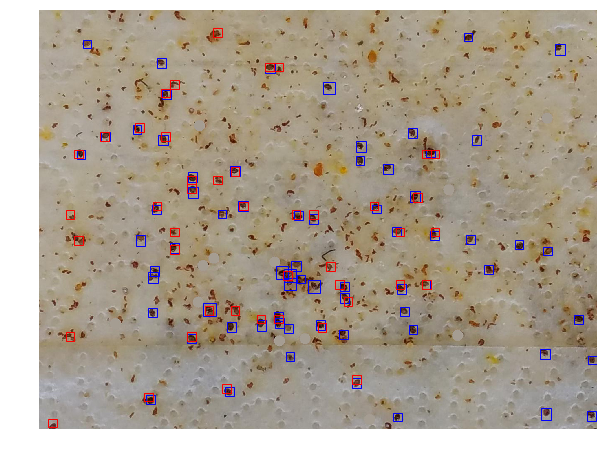

In [269]:
# visualize detected pattern vs ground truth in a test image
sample_idx = 8
detected_pattern = detect_part3(test_images_list[sample_idx])
annoations = test_annotations_xmls[sample_idx]

print("ground truth number:", len(annoations))
print("number detected:", len(detected_pattern))
fig, ax = plt.subplots(figsize=(10,10))
for i in range(len(annoations)):

    xmin = annoations[i]['bbox'][0]
    ymin = annoations[i]['bbox'][1]
    xw = annoations[i]['bbox'][2]
    yw = annoations[i]['bbox'][3]
    

    rect = patches.Rectangle((xmin, ymin), xw, yw,
            linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)
    

for i in range(len(detected_pattern)):
    xmin = detected_pattern[i][0]
    ymin = detected_pattern[i][1]
    xw = detected_pattern[i][2]
    yw = detected_pattern[i][3]

    rect = patches.Rectangle((xmin, ymin), xw, yw,
            linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

ax.imshow(test_images_list[sample_idx])
ax.axis('off')
plt.show()

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [ ]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)